In [1]:
import os
import glob
import pickle
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.stats import zscore, sem
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

# I may not always want to do this
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [2]:
from utils import (load_sessions, plot_comparison, analyze_coefficient_differences)

In [3]:
def plot_session(session_file, save_dir=None):
    # Load session data
    data_dict = loadmat(session_file)
    n_trials = data_dict['num_trials'][0][0]
    R = data_dict['R'][0]
    a = data_dict['a'][0]    
    choice_trials = (a==1)|(a==2)
    prob = data_dict['SessionData']['LR_Prob'][0][0]
    l_prob = list(list(zip(*prob))[0])
    R_choice = R[choice_trials]
    a_choice = a[choice_trials]
    
    # Calculate choice probabilities
    left_trials = (a==1)+0
    left_choice = left_trials[choice_trials]
    
    # Create trial outcome arrays
    left_reward = np.empty(n_trials)
    left_reward[:] = np.nan
    left_unreward = np.empty(n_trials)
    left_unreward[:] = np.nan
    right_reward = np.empty(n_trials)
    right_reward[:] = np.nan
    right_unreward = np.empty(n_trials)
    right_unreward[:] = np.nan
    miss_lick = np.empty(n_trials)
    miss_lick[:] = np.nan
    alarm_lick = np.empty(n_trials)
    alarm_lick[:] = np.nan
    
    # Mark trial outcomes
    left_reward[(a==1) & (R==1)] = 1
    right_reward[(a==2) & (R==1)] = 1
    left_unreward[(a==1) & (R==0)] = 1
    right_unreward[(a==2) & (R==0)] = 1
    miss_lick[a==4] = 1
    alarm_lick[R==3] = 1
    
    # Calculate smoothed probabilities
    left_series = pd.Series(left_trials)
    left_smooth = np.array(left_series.rolling(1).mean())
    l_prob_series = pd.Series(l_prob[0:n_trials])
    l_prob_smooth = np.array(l_prob_series.rolling(1).mean())
    
    # Create plot
    x_plot = np.arange(1, n_trials+1)
#     x_plot_shifted = np.arange(-1, n_trials-1)  # Shifted x-axis for smoothed curves
    fig, ax = plt.subplots(1, 1, figsize=[8, 1.5])
    
    # Plot probability traces with shifted x-axis
    ax.plot(x_plot, l_prob_smooth, 'k', alpha=0.5, label='Left reward assignment probability')
    ax.plot(x_plot, left_smooth, 'k', label='Left choice probability')
    
    # Plot trial outcomes with original x-axis
    ax.plot(x_plot, left_reward*1.05, '|', color='b', markersize=4, linewidth=0.6, alpha=.5, label='Left rewarded choice')
    ax.plot(x_plot, left_unreward*1.1, '|', color=[.5, .5, 1], markersize=4, linewidth=0.6, alpha=0.5, label='Left unrewarded choice')
    ax.plot(x_plot, right_reward*-.05, '|', color='r', markersize=4, linewidth=0.6, alpha=.5, label='Right rewarded choice')
    ax.plot(x_plot, right_unreward*-.1, '|', color=[1, .5, .5], markersize=4, linewidth=0.6, alpha=0.5, label='Right unrewarded choice')
    
    # Set plot properties
    ax.set_xlim([0, 400])
    ax.set_ylim([-.2, 1.2])
    ax.set_ylabel('P(left)', fontsize=7)
    ax.set_xlabel('Trial', fontsize=7)
    ax.set_yticks([0, .5, 1])
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(os.path.splitext(os.path.basename(session_file))[0])
    
    # Save figures if directory provided
    if save_dir is not None:
        base_name = os.path.splitext(os.path.basename(session_file))[0]
        fig.savefig(os.path.join(save_dir, f'{base_name}_session_plot_no_smooth.png'))
        fig.savefig(os.path.join(save_dir, f'{base_name}_session_plot_no_smooth.svg'))
    
    return fig, ax

In [4]:
def plot_session(session_file, save_dir=None):
    # Load session data
    data_dict = loadmat(session_file)
    n_trials = data_dict['num_trials'][0][0]
    R = data_dict['R'][0]
    a = data_dict['a'][0]    
    choice_trials = (a==1)|(a==2)
    prob = data_dict['SessionData']['LR_Prob'][0][0]
    l_prob = list(list(zip(*prob))[0])
    R_choice = R[choice_trials]
    a_choice = a[choice_trials]
    
    # Calculate choice probabilities
    left_trials = (a==1)+0
    left_choice = left_trials[choice_trials]
    
    # Create trial outcome arrays
    left_reward = np.empty(n_trials)
    left_reward[:] = np.nan
    left_unreward = np.empty(n_trials)
    left_unreward[:] = np.nan
    right_reward = np.empty(n_trials)
    right_reward[:] = np.nan
    right_unreward = np.empty(n_trials)
    right_unreward[:] = np.nan
    miss_lick = np.empty(n_trials)
    miss_lick[:] = np.nan
    alarm_lick = np.empty(n_trials)
    alarm_lick[:] = np.nan
    
    # Mark trial outcomes
    left_reward[(a==1) & (R==1)] = 1
    right_reward[(a==2) & (R==1)] = 1
    left_unreward[(a==1) & (R==0)] = 1
    right_unreward[(a==2) & (R==0)] = 1
    miss_lick[a==4] = 1
    alarm_lick[R==3] = 1
    
    # Calculate smoothed probabilities
    left_series = pd.Series(left_trials)
    left_smooth = np.array(left_series.rolling(5).mean())
    l_prob_series = pd.Series(l_prob[0:n_trials])
    l_prob_smooth = np.array(l_prob_series.rolling(5).mean())
    
    # Create plot
    x_plot = np.arange(1, n_trials+1)
    x_plot_shifted = np.arange(-1, n_trials-1)  # Shifted x-axis for smoothed curves
    fig, ax = plt.subplots(1, 1, figsize=[8, 1.5])
    
    # Plot probability traces with shifted x-axis
    ax.plot(x_plot_shifted, l_prob_smooth, 'k', alpha=0.5, label='Left reward assignment probability')
    ax.plot(x_plot_shifted, left_smooth, 'k', label='Left choice probability')
    
    # Plot trial outcomes with original x-axis
    ax.plot(x_plot, left_reward*1.05, '|', color='b', markersize=4, linewidth=0.6, alpha=.5, label='Left rewarded choice')
    ax.plot(x_plot, left_unreward*1.1, '|', color=[.5, .5, 1], markersize=4, linewidth=0.6, alpha=0.5, label='Left unrewarded choice')
    ax.plot(x_plot, right_reward*-.05, '|', color='r', markersize=4, linewidth=0.6, alpha=.5, label='Right rewarded choice')
    ax.plot(x_plot, right_unreward*-.1, '|', color=[1, .5, .5], markersize=4, linewidth=0.6, alpha=0.5, label='Right unrewarded choice')
    
    # Set plot properties
    ax.set_xlim([0, 400])
    ax.set_ylim([-.2, 1.2])
    ax.set_ylabel('P(left)', fontsize=7)
    ax.set_xlabel('Trial', fontsize=7)
    ax.set_yticks([0, .5, 1])
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(os.path.splitext(os.path.basename(session_file))[0])
    
    # Save figures if directory provided
    if save_dir is not None:
        base_name = os.path.splitext(os.path.basename(session_file))[0]
        fig.savefig(os.path.join(save_dir, f'{base_name}_session_plot_5trial_smooth.png'))
        fig.savefig(os.path.join(save_dir, f'{base_name}_session_plot_5trial_smooth.svg'))
    
    return fig, ax

In [5]:
params = {
#    'main_dir': 'behavior data directory',
#    'save_dir': 'save directory',
    'all_short': 'short_all_imaging',
    'all_long': 'long_all_imaging',
    'example_short': 'example_short',
    'example_long': 'example_long'
}

In [6]:
# Short example session
data_dir_condition1 = params['main_dir'] + params['example_short']
os.chdir(data_dir_condition1)
example_short_session = glob.glob('*.mat')

# Get results for short example
(alpha_rew_example_short, alpha_unr_example_short, decay_example_short,
 win_stay_nm_example_short, lose_switch_nm_example_short, coef_df_example_short,
 intercept_example_short, win_stay_example_short, lose_stay_example_short,
 win_switch_example_short, lose_switch_example_short, reward_rate_example_short,
 prediction_acc_RL_example_short, prediction_acc_LR_example_short,
 miss_rate_example_short, alarm_rate_example_short, mouse_ids_example_short,
 total_choice_trials_example_short, brain_areas_example_short, 
 reaction_times_example_short, total_rewarded_trials_example_short) = load_sessions(example_short_session)

# Long example session
data_dir_condition2 = params['main_dir'] + params['example_long']
os.chdir(data_dir_condition2)
example_long_session = glob.glob('*.mat')

# Get results for long example
(alpha_rew_example_long, alpha_unr_example_long, decay_example_long,
 win_stay_nm_example_long, lose_switch_nm_example_long, coef_df_example_long,
 intercept_example_long, win_stay_example_long, lose_stay_example_long,
 win_switch_example_long, lose_switch_example_long, reward_rate_example_long,
 prediction_acc_RL_example_long, prediction_acc_LR_example_long,
 miss_rate_example_long, alarm_rate_example_long, mouse_ids_example_long,
 total_choice_trials_example_long, brain_areas_example_long,
 reaction_times_example_long, total_rewarded_trials_example_long) = load_sessions(example_long_session)

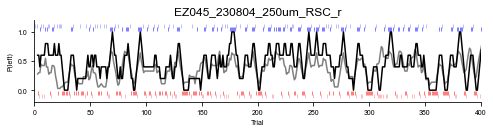

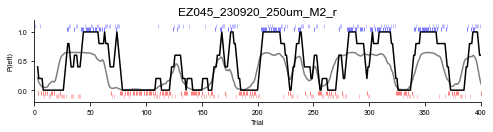

In [7]:
# Plot short session
os.chdir(data_dir_condition1)
for session_file in example_short_session:
    fig, ax = plot_session(session_file, save_dir=params['save_dir'])
#     plt.close(fig)

# Plot long session
os.chdir(data_dir_condition2)
for session_file in example_long_session:
    fig, ax = plot_session(session_file, save_dir=params['save_dir'])
#     plt.close(fig)

In [9]:
# Load all short sessions
data_dir_condition1 = params['main_dir'] + params['all_short']
os.chdir(data_dir_condition1)
all_short_session = glob.glob('*.mat')

# Get results for all short sessions
(alpha_rew_all_short, alpha_unr_all_short, decay_all_short,
 win_stay_nm_all_short, lose_switch_nm_all_short, coef_df_all_short,
 intercept_all_short, win_stay_all_short, lose_stay_all_short,
 win_switch_all_short, lose_switch_all_short, reward_rate_all_short,
 prediction_acc_RL_all_short, prediction_acc_LR_all_short,
 miss_rate_all_short, alarm_rate_all_short, mouse_ids_all_short,
 total_choice_trials_all_short, brain_areas_all_short, 
 reaction_times_all_short, total_rewarded_trials_all_short) = load_sessions(all_short_session)

# Load all long sessions
data_dir_condition2 = params['main_dir'] + params['all_long']
os.chdir(data_dir_condition2)
all_long_session = glob.glob('*.mat')

# Get results for all long sessions
(alpha_rew_all_long, alpha_unr_all_long, decay_all_long,
 win_stay_nm_all_long, lose_switch_nm_all_long, coef_df_all_long,
 intercept_all_long, win_stay_all_long, lose_stay_all_long,
 win_switch_all_long, lose_switch_all_long, reward_rate_all_long,
 prediction_acc_RL_all_long, prediction_acc_LR_all_long,
 miss_rate_all_long, alarm_rate_all_long, mouse_ids_all_long,
 total_choice_trials_all_long, brain_areas_all_long,
 reaction_times_all_long, total_rewarded_trials_all_long) = load_sessions(all_long_session)

Group 1 (Short): 35 sessions, 10 unique mice
Group 2 (Long): 29 sessions, 7 unique mice
Analyzing RewC10: 64 observations across 11 mice
  Mixed-effects model p-value for RewC10: 0.7599
Analyzing RewC9: 64 observations across 11 mice
  Mixed-effects model p-value for RewC9: 0.0583
Analyzing RewC8: 64 observations across 11 mice
  Mixed-effects model p-value for RewC8: 0.5013
Analyzing RewC7: 64 observations across 11 mice
  Mixed-effects model p-value for RewC7: 0.5266
Analyzing RewC6: 64 observations across 11 mice
  Mixed-effects model p-value for RewC6: 0.1294
Analyzing RewC5: 64 observations across 11 mice
  Mixed-effects model p-value for RewC5: 0.0792
Analyzing RewC4: 64 observations across 11 mice
  Mixed-effects model p-value for RewC4: 0.0000
Analyzing RewC3: 64 observations across 11 mice
  Mixed-effects model p-value for RewC3: 0.0000
Analyzing RewC2: 64 observations across 11 mice
  Mixed-effects model p-value for RewC2: 0.0000
Analyzing RewC1: 64 observations across 11 mic

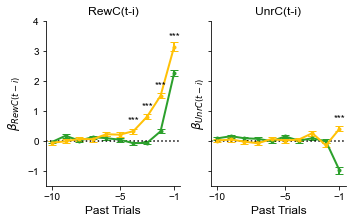

In [10]:
# Run statistical analysis
p_values, significance = analyze_coefficient_differences(
    coef_df_all_short, coef_df_all_long, 
    'Short', 'Long',
    mouse_ids1=mouse_ids_all_short,  # Pass the mouse IDs directly
    mouse_ids2=mouse_ids_all_long)

# Create plot
fig, axes = plot_comparison(coef_df_all_short, coef_df_all_long, 
                          'Short', 'Long', save_path=save_path)

# Add significance markers to the plot
y_offset = 0.2  # Offset for significance markers
max_y_val = -np.inf  # To track highest point for legend placement

# Apply FDR correction to p-values
from statsmodels.stats.multitest import fdrcorrection

# Separate p-values for RewC and UnrC columns
rewc_cols = [col for col in p_values.keys() if col.startswith('RewC')]
unrc_cols = [col for col in p_values.keys() if col.startswith('UnrC')]

# Extract p-values in the same order as the columns
rewc_pvals = [p_values[col] for col in rewc_cols]
unrc_pvals = [p_values[col] for col in unrc_cols]

# Apply FDR correction separately to each set of p-values
_, rewc_pvals_corrected = fdrcorrection(rewc_pvals, alpha=0.05)
_, unrc_pvals_corrected = fdrcorrection(unrc_pvals, alpha=0.05)

# Create new significance dictionaries with corrected p-values
fdr_significance = {}
for col, p_orig, p_corrected in zip(rewc_cols, rewc_pvals, rewc_pvals_corrected):
    if p_corrected < 0.001:
        fdr_significance[col] = '***'
    elif p_corrected < 0.01:
        fdr_significance[col] = '**'
    elif p_corrected < 0.05:
        fdr_significance[col] = '*'
    else:
        fdr_significance[col] = ''
    print(f"{col}: original p={p_orig:.4f}, FDR-corrected p={p_corrected:.4f}, significance: {fdr_significance[col]}")

for col, p_orig, p_corrected in zip(unrc_cols, unrc_pvals, unrc_pvals_corrected):
    if p_corrected < 0.001:
        fdr_significance[col] = '***'
    elif p_corrected < 0.01:
        fdr_significance[col] = '**'
    elif p_corrected < 0.05:
        fdr_significance[col] = '*'
    else:
        fdr_significance[col] = ''
    print(f"{col}: original p={p_orig:.4f}, FDR-corrected p={p_corrected:.4f}, significance: {fdr_significance[col]}")

for ax_idx, col_prefix in enumerate(['RewC', 'UnrC']):
    # Get columns for current plot (RewC or UnrC)
    cols = [col for col in coef_df_all_short.columns if col.startswith(col_prefix)]
    
    # Calculate mean values for both groups
    means1 = np.array([coef_df_all_short[col].mean() for col in cols])
    means2 = np.array([coef_df_all_long[col].mean() for col in cols])
    
    # Track the maximum y value across both plots for legend placement
    max_y_val = max(max_y_val, np.max(means1), np.max(means2))
    
    # Add significance markers at appropriate positions
    for i, col in enumerate(cols):
        x = -10 + i  # x-position (-10, -9, ..., -1)
        if col in fdr_significance and fdr_significance[col]:
            # Place asterisk above the higher mean with offset
            y_pos = max(means1[i], means2[i]) + y_offset
            axes[ax_idx].text(x, y_pos, fdr_significance[col], ha='center', va='bottom', fontsize=10)

# Add legend for significance markers (placed based on data extent)
legend_x = 0.85  # X position as fraction of figure width
legend_y = 0.15  # Y position as fraction of figure height
# fig.text(legend_x, legend_y, "* p<0.05\n** p<0.01\n*** p<0.001\n(FDR-corrected)", fontsize=8)

# Save the figure with added significance markers
fig.savefig(save_path + '_with_stats_fdr.png', dpi=300)
fig.savefig(save_path + '_with_stats_fdr.svg')

# plt.close(fig)


===== Mixed Effects Analysis of Behavioral Metrics =====

----- Choice bias Analysis -----
Group 1 (Short): 35 sessions, 10 unique mice
Group 2 (Long): 29 sessions, 7 unique mice
Analyzing Choice bias: 64 observations across 11 mice
  Mixed-effects model p-value for Choice bias: 0.5626
Short task Choice bias: 0.1163 ± 0.0772
Long task Choice bias: 0.0419 ± 0.0663
Significance:  (p = 0.5626)

----- Reward rate Analysis -----
Group 1 (Short): 35 sessions, 10 unique mice
Group 2 (Long): 29 sessions, 7 unique mice
Analyzing Reward rate: 64 observations across 11 mice
  Mixed-effects model p-value for Reward rate: 0.0000
Short task Reward rate: 0.5731 ± 0.0064
Long task Reward rate: 0.5369 ± 0.0059
Significance: *** (p = 0.0000)

----- Miss rate Analysis -----
Group 1 (Short): 35 sessions, 10 unique mice
Group 2 (Long): 29 sessions, 7 unique mice
Analyzing Miss rate: 64 observations across 11 mice
  Mixed-effects model p-value for Miss rate: 0.5435
Short task Miss rate: 0.1112 ± 0.0139
Lon

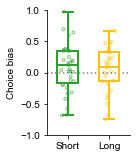

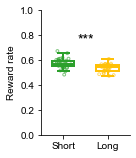

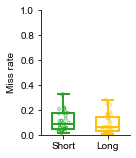

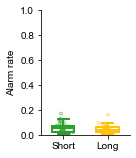

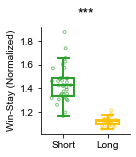

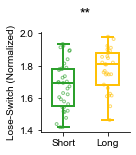

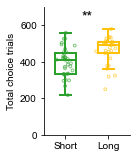

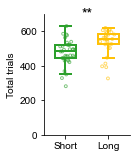

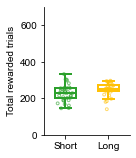

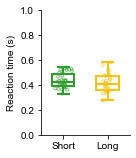

In [11]:
# Add mixed effects model comparisons for behavioral metrics
print("\n===== Mixed Effects Analysis of Behavioral Metrics =====")

# Function to run mixed effects analysis on scalar metrics
def analyze_behavior_metric(metric1, metric2, metric_name, mouse_ids1, mouse_ids2):
    """Run mixed effects analysis on behavioral metrics"""
    print(f"\n----- {metric_name} Analysis -----")
    
    # Convert to DataFrames to match the expected input of analyze_coefficient_differences
    df1 = pd.DataFrame({metric_name: metric1})
    df2 = pd.DataFrame({metric_name: metric2})
    
    # Run mixed effects analysis
    p_values, significance = analyze_coefficient_differences(
        df1, df2, 'Short', 'Long', 
        mouse_ids1=mouse_ids1, mouse_ids2=mouse_ids2
    )
    
    # Calculate means and standard errors
    mean1, mean2 = np.mean(metric1), np.mean(metric2)
    se1, se2 = stats.sem(metric1), stats.sem(metric2)
    
    print(f"Short task {metric_name}: {mean1:.4f} ± {se1:.4f}")
    print(f"Long task {metric_name}: {mean2:.4f} ± {se2:.4f}")
    print(f"Significance: {significance[metric_name] if metric_name in significance else 'n.s.'} (p = {p_values[metric_name]:.4f})")
    
    # Create data for boxplot
    data = [metric1, metric2]
    labels = ['Short', 'Long']
    colors = ['#2ca02c', '#FFC107']  # Medium-dark green and saturated golden yellow from plot_comparison
    
    # Create and save boxplot
    fig, ax = plt.subplots(figsize=(2, 2.3))
    boxplot = ax.boxplot(data, patch_artist=True, widths=0.5, showfliers=False)
    
    # Style the boxplot elements with colored edges but transparent fill
    for i, (box, color) in enumerate(zip(boxplot['boxes'], colors)):
        box.set(facecolor='none')  # No fill
        box.set(edgecolor=color, linewidth=2)  # Thicker colored edges for better visibility
        
        # Make all elements for this box the same color with thicker lines
        for element in ['whiskers', 'caps', 'medians']:
            j = i*2 if element == 'whiskers' or element == 'caps' else i
            item = boxplot[element][j]
            item.set(color=color, linewidth=2)
            if element == 'whiskers' or element == 'caps':
                item = boxplot[element][j+1]
                item.set(color=color, linewidth=2)
    
    # Add individual data points as scatter (jittered) with transparent fill and colored edges
    for i, d in enumerate(data):
        # Calculate jitter
        x = np.random.normal(i+1, 0.08, size=len(d))
        ax.scatter(x, d, s=8, facecolor='none', edgecolor=colors[i], linewidth=1, alpha=0.6)
    
    # Add significance marker if significant
    if metric_name in significance and significance[metric_name]:
        max_val = max(np.max(metric1), np.max(metric2))
        # Position the star slightly above the highest point
        y_pos = max_val + 0.05 * max_val  
        ax.text(1.5, y_pos, significance[metric_name], ha='center', va='bottom', fontsize=14)
    
    # Set axis labels and title
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric_name)
#     ax.set_title(f"{metric_name} Comparison")
    
    # Set specific y-limits for reward rate, miss rate, and alarm rate
    if metric_name in ['Reward rate', 'Miss rate', 'Alarm rate', 'Reaction time (s)']:
        ax.set_ylim(0, 1)
    elif metric_name in ['Total choice trials','Total trials','Total rewarded trials']:
        ax.set_ylim(0, 700)
    elif metric_name == 'Choice bias':
        ax.set_ylim(-1, 1)
    
    # Add zero reference line for metrics where zero is meaningful
    if metric_name in ['Choice bias']:
        ax.axhline(y=0, color='k', linestyle=':', alpha=0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save figure
    save_path = os.path.join(params['save_dir'], f"{metric_name.lower().replace(' ', '_')}_comparison")
    fig.tight_layout()
    fig.savefig(save_path + '.png', dpi=300)
    fig.savefig(save_path + '.svg')
    
    return p_values, significance

# Run analysis on intercept (choice bias)
bias_pvals, bias_sig = analyze_behavior_metric(
    intercept_all_short, intercept_all_long, 
    'Choice bias', mouse_ids_all_short, mouse_ids_all_long
)

# Run analysis on reward rate
reward_pvals, reward_sig = analyze_behavior_metric(
    reward_rate_all_short, reward_rate_all_long, 
    'Reward rate', mouse_ids_all_short, mouse_ids_all_long
)

# Run analysis on miss rate
miss_pvals, miss_sig = analyze_behavior_metric(
    miss_rate_all_short, miss_rate_all_long, 
    'Miss rate', mouse_ids_all_short, mouse_ids_all_long
)

# Run analysis on alarm rate
alarm_pvals, alarm_sig = analyze_behavior_metric(
    alarm_rate_all_short, alarm_rate_all_long, 
    'Alarm rate', mouse_ids_all_short, mouse_ids_all_long
)

# Run analysis on win-stay and lose-switch (normalized)
winstay_pvals, winstay_sig = analyze_behavior_metric(
    win_stay_nm_all_short, win_stay_nm_all_long, 
    'Win-Stay (Normalized)', mouse_ids_all_short, mouse_ids_all_long
)

loseswitch_pvals, loseswitch_sig = analyze_behavior_metric(
    lose_switch_nm_all_short, lose_switch_nm_all_long, 
    'Lose-Switch (Normalized)', mouse_ids_all_short, mouse_ids_all_long
)

# Run analysis on total choice trials
choice_trials_pvals, choice_trials_sig = analyze_behavior_metric(
    total_choice_trials_all_short, total_choice_trials_all_long, 
    'Total choice trials', mouse_ids_all_short, mouse_ids_all_long
)

# Calculate total trials (including choices, misses, and alarms)
total_trials_all_short = []
for session_file in all_short_session:
    data_dict = loadmat(os.path.join(data_dir_condition1, session_file))
    total_trials_all_short.append(data_dict['num_trials'][0][0])

total_trials_all_long = []
for session_file in all_long_session:
    data_dict = loadmat(os.path.join(data_dir_condition2, session_file))
    total_trials_all_long.append(data_dict['num_trials'][0][0])

# Run analysis on total trials
total_trials_pvals, total_trials_sig = analyze_behavior_metric(
    total_trials_all_short, total_trials_all_long, 
    'Total trials', mouse_ids_all_short, mouse_ids_all_long
)

# Run analysis on total rewarded trials
total_rewarded_pvals, total_rewarded_sig = analyze_behavior_metric(
    total_rewarded_trials_all_short, total_rewarded_trials_all_long, 
    'Total rewarded trials', mouse_ids_all_short, mouse_ids_all_long
)


# Run analysis on reaction times
reaction_time_pvals, reaction_time_sig = analyze_behavior_metric(
    reaction_times_all_short, reaction_times_all_long, 
    'Reaction time (s)', mouse_ids_all_short, mouse_ids_all_long
)